In [65]:
import numpy as np  
import matplotlib.pyplot as plt
import scipy.integrate as spi

from toolbox.utils import *
from quaternion import *



In [66]:
# Orbital data 

rE = 6371 # Earth radius [km]
mu = 398600 # Earth gravitational parameter [km^3/s^2]

# Orbital parameters

altitude = 1000 # altitude [km]	

a = rE + altitude # circular orbit
e = 0 # circular orbit
raan = np.deg2rad(50) # right ascension of the ascending node
i = np.deg2rad(55) # inclination
truan0 = 0 # true anomaly at t=0


# Derived quantities (semilatus rectum, h angular momentum)
p = a
h = np.sqrt(mu*p)
truan_dot = h/a**2 # true anomaly rate for a circular orbit, in rad/s


In [67]:
# Spacecraft inertia matrix 
Jc = np.array([[1800, 100, -200], [100, 2200, 300], [-200, 300, 2500]]) # Inertia matrix of the spacecraft [kg m^2]

# Inititial conditions for the attitude of the satellite
q0_1 = -0.1
q0_2 = -0.3
q0_3 = 0.5
q0_0 = np.sqrt(1 - ( q0_1**2 + q0_2**2 + q0_3**2))

q0 = Quaternion(np.array([q0_0, q0_1, q0_2, q0_3]))

om0 = np.array([-0.01, 0.01, 0]) # Initial angular velocity [rad/s]

In [68]:
## Wheel parameters
Is = 1 # kg m^2
It = 0.5 # kg m^2

a1 = np.array([[1], [1], [1]]) / np.sqrt(3)
a2 = np.array([[1], [-1], [1]]) / np.sqrt(3)
a3 = np.array([[-1], [1], [1]]) / np.sqrt(3)
a4 = np.array([[-1], [-1], [1]]) / np.sqrt(3)

om_w0 = [0.5, -0.5, 0.5, -0.5] # Initial wheel angular velocities [rad/s]


# Assemble all wheels in a matrix A
A_w = Is*np.hstack([a1, a2, a3, a4])

In [69]:
# Control parameters
nat_freq = 0.05
csi = 1

# Control gain matrices
c1 = 2*nat_freq**2
c2 = csi/nat_freq

A = c1*np.eye(3)
B = c2*np.eye(3)

In [70]:
t0 = 0
tf = 10

In [71]:
# Commanded frame and angular velocity 

Rb = np.array([[0,1,0],[0,0,-1],[-1,0,0]])  # Nadir pointing matrix in LVLH

def b_c(theta_t):
    # Commanded body axes are a clockwise rotation of theta along
    # the third body axis (the one aligned with radial direction)
    return Rz(-theta_t)*Rb

def om_c(theta_t, args):
    # Commanded angular velocity in commanded frame
    theta_dot = args
    return theta_dot*np.array([[-np.sin(theta_t)], [-np.cos(theta_t)], [1]])

om_c_dot = np.zeros((3,1))
Mc = np.zeros((3,1)) # External disturbance torque

In [72]:
def ode_integrate(t, nu: np.array):
    # State is composed from the quaternion and the angular velocity of the body
    # plus the angular velocities of the wheels
    # nu = [q0, q1, q2, q3, om1, om2, om3, vec(om_s)] as a row vector
    # Compute true anomaly
    
    truan = truan_dot*t + truan0

    # Use truan to get the commanded frame and angular velocity
    q_c = Quaternion()
    Rc = b_c(truan)
    q_c.fromR(Rc)

    omc = om_c(truan, truan_dot)

    # Extract state variables
    q_b = Quaternion(nu[0:4])
    om = nu[4:7] 
    om = om.reshape((3,1))

    q0b = q_b.q0()
    qb = q_b.q()
    q0c = q_c.q0()
    qc = q_c.q()

    om_s = nu[7:11]
    om_s = om_s.T

    # Compute the attitude error
    q0e = q0c*q0b + qc.T@qb
    qe = qc*q0b + (-q0c*np.eye(3) + skew(qc))@qb
    
    q_err = Quaternion(np.vstack([q0e, qe]))
    om_d = om - omc

    # Compute the control torque
    Tc = skew(om)@Jc@om + Jc@om_c_dot - Jc@np.linalg.inv(A)@B@om_d - Jc@np.linalg.inv(A)@qe

    # Steering law -- compute om_s_dot
    om_s_dot = -np.transpose(A_w)@np.linalg.inv(A_w@np.transpose(A_w))@Tc


    dnu = np.zeros((11,1))
    # If no gyro effect, we dont need om_s
    # Ta = -skew(om)@A_w@om_s 
    om_dot = np.linalg.inv(Jc)@(Mc - skew(om)@Jc@om - A_w@om_s_dot)
    
    q0_dot = -0.5*om.T@qb
    q_b_dot = 0.5*(q0b*om - skew(om)@qb)

    dnu[0] = q0_dot
    dnu[1:4] = q_b_dot
    dnu[4:7] = om_dot
    dnu[7:11] = om_s_dot

    return dnu.flatten()

In [73]:
sol = spi.solve_ivp(ode_integrate, (t0, tf), np.concatenate((q0.toArray(), om0, om_w0)), t_eval=np.linspace(t0, tf, tf-t0 ))

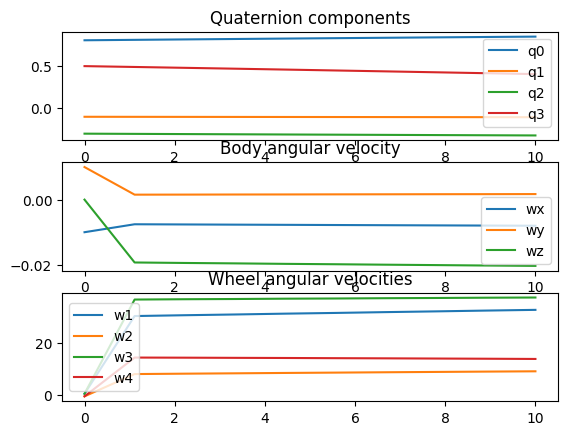

In [74]:
t = sol.t	
sol = sol.y
# Plot the results
fig, axs = plt.subplots(3, 1)
axs[0].plot(t, sol[0,:], label='q0')
axs[0].plot(t, sol[1,:], label='q1')
axs[0].plot(t, sol[2,:], label='q2')
axs[0].plot(t, sol[3,:], label='q3')
axs[0].legend()
axs[0].set_title('Quaternion components')
axs[1].plot(t, sol[4,:], label='wx')
axs[1].plot(t, sol[5,:], label='wy')
axs[1].plot(t, sol[6,:], label='wz')
axs[1].legend()
axs[1].set_title('Body angular velocity')
axs[2].plot(t, sol[7,:], label='w1')
axs[2].plot(t, sol[8,:], label='w2')
axs[2].plot(t, sol[9,:], label='w3')
axs[2].plot(t, sol[10,:], label='w4')
axs[2].legend()
axs[2].set_title('Wheel angular velocities')
plt.show()

In [34]:
print(sol[:])

[[ 0.80622577]
 [-0.1       ]
 [-0.3       ]
 [ 0.5       ]
 [-0.01      ]
 [ 0.01      ]
 [ 0.        ]
 [ 0.5       ]
 [-0.5       ]
 [ 0.5       ]
 [-0.5       ]]
